In [1]:
import cv2
import numpy as np
from cellpose import models
import matplotlib.pyplot as plt
import os
from scipy import ndimage
from collections import defaultdict
import time

def getFramesFromVideo(video_path:str):
    vidcap = cv2.VideoCapture(video_path)
    frames = []
    if vidcap is not None:
        success,image = vidcap.read()
        count = 0
        while success:
            frames.append(image)      
            success,image = vidcap.read()
            count += 1
    return frames

def combineMasksWithOverlap(mask1, mask2):
    # Initialize an empty mask for the combined result
    combined_mask = np.zeros_like(mask1, dtype=np.uint16)

    # Assign unique labels to the first mask
    label_offset = 0
    for i in range(1, mask1.max() + 1):
        combined_mask[mask1 == i] = i + label_offset

    # Assign unique labels to the second mask
    label_offset = combined_mask.max()
    for i in range(1, mask2.max() + 1):
        combined_mask[mask2 == i] = i + label_offset

    # Perform connected components labeling on the combined mask
    labeled_mask, num_labels = ndimage.label(combined_mask > 0)

    return labeled_mask, num_labels


def processImageForCellpose(frame):
    """
    Enhanced preprocessing for better cell detection
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray_frame = frame
    
    return gray_frame


In [2]:
# load video
video_path = "./extract_metrics/bw_longer.mp4"

frames = getFramesFromVideo(video_path)# process video
print(len(frames))
print(frames[0].shape)

721
(1460, 1920, 3)


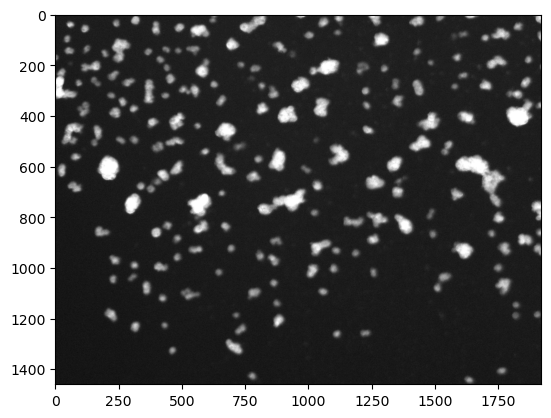

In [3]:
frame0 = frames[500]
processed_frame = processImageForCellpose(frame0)
plt.imshow(processed_frame, cmap='gray')
plt.show()


In [5]:
# Try different models
model_cyto = models.Cellpose(gpu=True, model_type='cyto')

In [6]:
import time
diameter = None
flow_threshold = 1.0
start_time = time.time()
masks_cyto = model_cyto.eval(processed_frame, channels=[0,0], diameter=diameter, flow_threshold=flow_threshold)[0]
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")







Time taken: 31.20107412338257 seconds


In [7]:
def get_overlay(masks, processed_frame):
    # Create RGB image from processed frame
    background = np.stack([processed_frame]*3, axis=-1)

    # Create mask overlay
    overlay = np.zeros_like(background)
    overlay[masks > 0] = [0, 255, 0]  # Green for mask overlay

    # Combine background and overlay
    combined = background.copy()
    alpha = 0.3  # Adjust transparency (0.0 to 1.0)
    combined[masks > 0] = background[masks > 0] * (1 - alpha) + overlay[masks > 0] * alpha
    return combined

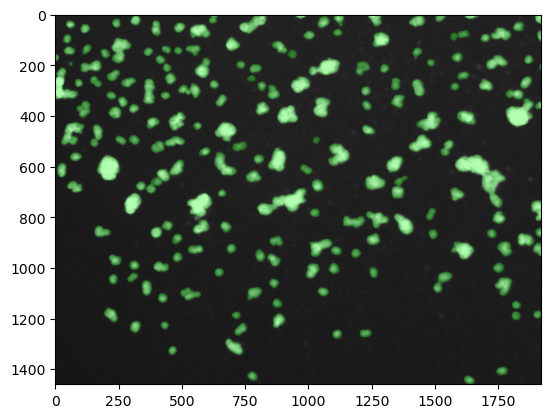

In [11]:
overlay_cyto = get_overlay(masks_cyto, processed_frame)

plt.imshow(overlay_cyto)



